In [2]:
!pip install -q kaggle
!mkdir -p  ~‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍/.kaggle/
!wget -qO ~/.kaggle/kaggle.json https://github.com/MohammadRaziei/Deep-Learning-Course/raw/master/Project/kaggle/key/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

/root/.kaggle/kaggle.json: No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
import tensorflow as tf
# from kaggle_datasets import KaggleDatasets
data_path = "../input/cassava-leaf-disease-classification"

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    IS_TPU = True
    # GCS_PATH = KaggleDatasets().get_gcs_path()
    # data_path = GCS_PATH
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    IS_TPU = False
    gpus = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
import os
import pandas as pd

train_csv_data_path  = os.path.join(data_path, "train.csv")
label_json_data_path = os.path.join(data_path, "label_num_to_disease_map.json")
images_dir_data_path = os.path.join(data_path, "train_images")

train_csv = pd.read_csv(train_csv_data_path)
train_csv['label'] = train_csv['label'].astype('string')

label_class = pd.read_json(label_json_data_path, orient='index')
label_class = label_class.values.flatten().tolist()

In [ ]:
train_csv

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import tensorflow as tf


label_encoder = LabelEncoder()
label_encoder.fit(label_class)
func_num_or_list = lambda func, x: func(x) if isinstance(x, (list,np.ndarray,tf.Tensor)) else func([x])[0] 
label_encode = lambda arr_str: func_num_or_list(label_encoder.transform,arr_str)
label_decode = lambda arr: func_num_or_list(label_encoder.inverse_transform,arr)

label_onehotEncoder = OneHotEncoder()
label_onehotEncoder.fit(np.arange(5).reshape(-1,1))
def onehot_decode(arr):
  np_arr = arr.numpy() if isinstance(arr, tf.Tensor) else np.array(arr)
  if len(np_arr.shape) is 1: np_arr = np_arr.reshape(1,-1)
  return label_onehotEncoder.inverse_transform(np_arr).squeeze() 
label_name = lambda arr: label_decode(onehot_decode(arr).tolist()).tolist()
num_classes = len(label_class)

pd.DataFrame(label_encoder.classes_, columns=['Label names'])

,Label names
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


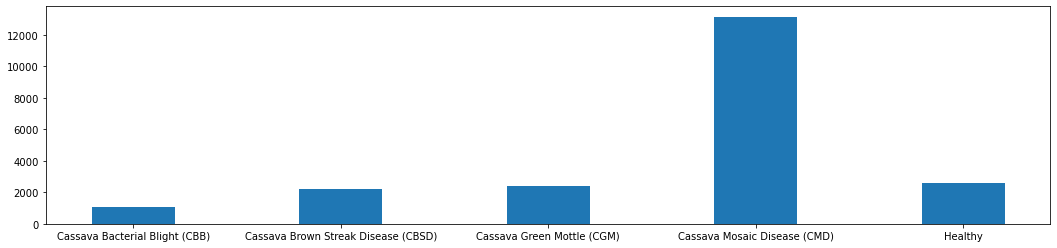

21397


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tags = label_decode(np.arange(5))
all_labels = np.array(list(map(int, train_csv.iloc[:,1])))

def plot_hist_labels(all_labels):
  fig, ax = plt.subplots()
  all_labels_counts, _, _= plt.hist(all_labels, bins=np.arange(-0.5,5.5), rwidth=0.4)
  plt.xticks(np.arange(5))
  ax.set_xticklabels(tags)
  fig.set_size_inches(18,4)
  plt.show()
  return all_labels_counts

all_labels_counts = plot_hist_labels(all_labels)
num_all_labels = len(all_labels)
print(num_all_labels)

In [ ]:
from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',np.unique(all_labels),all_labels)
class_weights = np.sum(all_labels_counts)/all_labels_counts/num_classes
# class_weight_dict = dict(enumerate(class_weights))
class_weight_dict = {0:2.2, 1:1., 2:1.5, 3:0.7, 4:1}
class_weight_dict

{0: 2.2, 1: 1.0, 2: 1.5, 3: 0.7, 4: 1}

In [ ]:
from functools import partial
import tensorflow as tf
import os, pathlib, shutil
from tqdm.auto import tqdm

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16
IMAGE_SIZE = [512, 512]
DEFAULT_FUNC = lambda n:n
# TRAIN_TFRECORDS_PATH = os.path.join(data_path, 'train_tfrecords')

def decode_image(image, image_size):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, image_size)
    return image

def read_tfrecord(example, labeled=True, image_size=[*IMAGE_SIZE, 3], label_transform=DEFAULT_FUNC, image_transform=DEFAULT_FUNC, load_filename=False):
    tfrecord_format = (
        {
            "image_name": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else
        {
            "image_name": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
        }
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = image_transform(decode_image(example["image"], image_size))
    ret = (image,)
    if load_filename:
        filename = example['image_name']
        ret +=(filename,)
    if labeled:
        label = label_transform(tf.cast(example["target"], tf.int32))
        ret +=(label,)
    return ret

def load_dataset(filenames, labeled, image_size, label_transform=DEFAULT_FUNC, image_transform=DEFAULT_FUNC, disable_order=True, load_filename=False):
    ignore_order = tf.data.Options()
    if disable_order: ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order)  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled, image_size=image_size, label_transform=label_transform, image_transform=image_transform, load_filename=load_filename), 
        num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

def get_dataset(filenames, labeled=True, batch_size=BATCH_SIZE, image_size=[*IMAGE_SIZE, 3], label_transform=DEFAULT_FUNC, image_transform=DEFAULT_FUNC, reshuffle_each_iteration=None, disable_order=True, cache=False ,load_filename=False):
    dataset = load_dataset(filenames, labeled=labeled, image_size=image_size, label_transform=label_transform, image_transform=image_transform, disable_order=disable_order, load_filename=load_filename)
    if reshuffle_each_iteration: dataset = dataset.shuffle(2048, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    if cache: dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

def extract_dataset(filenames, save_dir='.', batch_size=BATCH_SIZE, labeled=True, image_size=[*IMAGE_SIZE,3], flush_path=True, num_samples=None):
    if flush_path: shutil.rmtree(save_dir, ignore_errors=True)
    pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True)

    dataset = get_dataset(filenames, image_size=image_size, labeled=labeled, load_filename=True, disable_order=False, reshuffle_each_iteration=False)
    if num_samples is None:
      print('Computing the number of samples:', end=' ')
      num_samples = tf.reduce_sum([y.shape for _,y,_ in dataset]) if labeled else tf.reduce_sum([y.shape for _,y in dataset])
      print(num_samples.numpy(), 'samples')

    images_path = []
    if labeled: label_list = []
    num_iter = tf.math.ceil(num_samples/32)
    iterator = iter(dataset)
    for _ in tqdm(tf.range(num_iter)):
      item = next(iterator)
      images, image_names = item[:2]
      if labeled:  labels = item[2].numpy()
      for i in tf.range(image_names.shape):
        image_path = os.path.join(save_dir, image_names[i].numpy().decode("utf-8"))
        tf.keras.preprocessing.image.save_img(image_path, images[i])

        if labeled: label_list.append(labels[i])
        images_path.append(image_path)
    del dataset, iterator

    if labeled:
      return np.array(images_path), np.array(label_list)
    else:
      return np.array(images_path)


import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(7, 7))
    plt.tight_layout()
    plt.subplots_adjust(right=2., top=2.)
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        plt.title(label_decode(label_batch[n]), fontsize=10)
        plt.axis("off")
    plt.show()

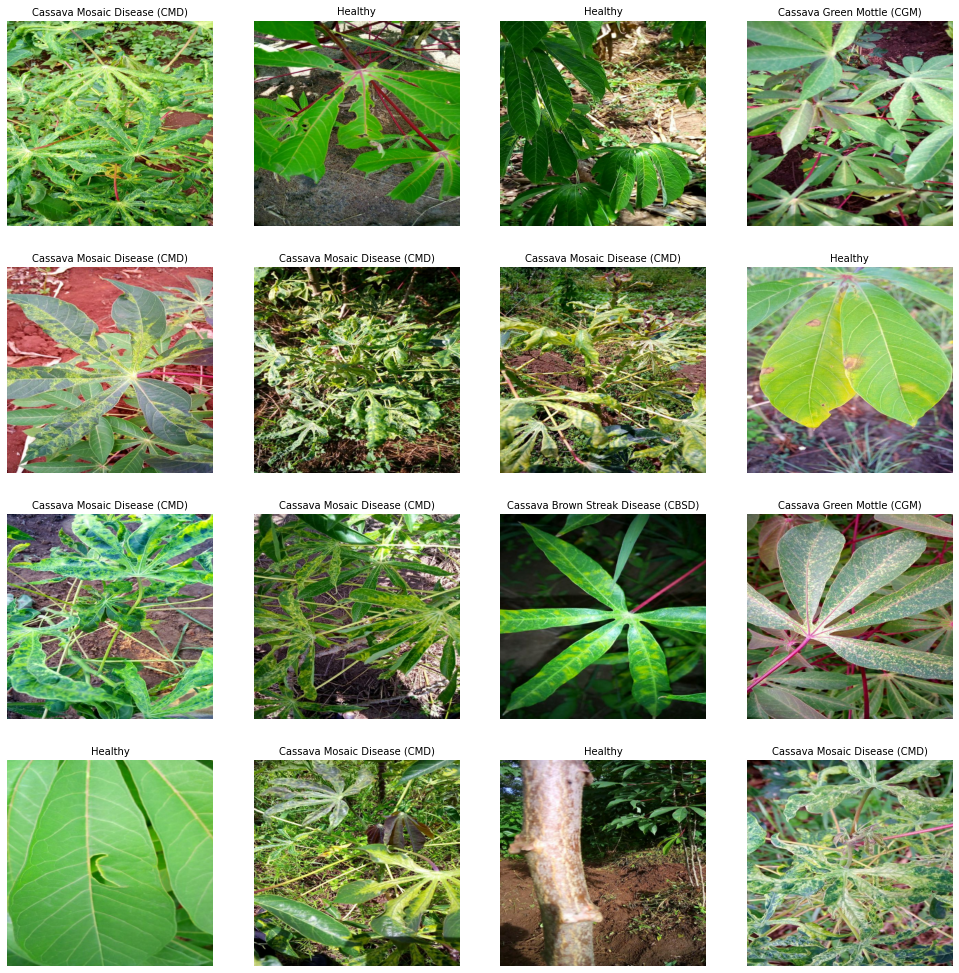

In [ ]:
# sample_dataset = get_dataset([os.path.join(data_path,"train_tfrecords","ld_train15-1327.tfrec")])
sample_dataset = get_dataset([data_path + '/train_tfrecords/ld_train15-1327.tfrec'])
image_batch, label_batch = next(iter(sample_dataset))
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

FILENAMES = tf.io.gfile.glob(data_path + '/train_tfrecords/ld_train*.tfrec')
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(FILENAMES, test_size=0.1, random_state=5)
TEST_FILENAMES = tf.io.gfile.glob(data_path + '/test_tfrecords/ld_test*.tfrec')
print("All TFRecord Files:      ", len(FILENAMES))
print("Train TFRecord Files:    ", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:      ", len(TEST_FILENAMES))

num_classes = len(label_class)
batch_size = 8# 16 * strategy.num_replicas_in_sync
image_size = [320,320]
label_transform = lambda x: x#tf.one_hot(x, depth=num_classes)
# image_rescale = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255), 
#     tf.keras.layers.experimental.preprocessing.Resizing(400, 400)])
def image_rescale(img):
    return tf.image.random_crop(img, size=[*image_size,3])/127.5 - 1
    
def image_transform(img):
    im = image_rescale(img)
    im = tf.image.random_brightness(im, 0.18)
    im = tf.image.random_flip_left_right(im)
    im = tf.image.random_flip_up_down(im)
    im = tf.image.random_contrast(im, lower=0.8, upper=1.15)
#     im = tf.clip_by_value(im, 0., 1.)
    return im

all_dataset = get_dataset(FILENAMES, label_transform=label_transform, image_transform=image_transform, batch_size=batch_size)
solid_dataset = get_dataset(FILENAMES, label_transform=label_transform, image_transform=image_transform, batch_size=batch_size, disable_order=True, reshuffle_each_iteration=False, cache=False)


train_dataset = get_dataset(TRAINING_FILENAMES, label_transform=label_transform, image_transform=image_transform, batch_size=batch_size)
valid_dataset = get_dataset(VALID_FILENAMES, label_transform=label_transform, image_transform=image_rescale, batch_size=batch_size, disable_order=False, reshuffle_each_iteration=False, cache=True)
test_dataset = get_dataset(TEST_FILENAMES, labeled=False, image_transform=image_rescale, batch_size=batch_size, disable_order=False, reshuffle_each_iteration=False)

All TFRecord Files:       16
Train TFRecord Files:     14
Validation TFRecord Files: 2
Test TFRecord Files:       1


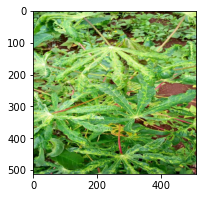

In [ ]:
# Add the image to a batch
image = image_batch[0]

plt.figure(figsize=(3, 3))
plt.imshow(image/255)
# plt.axis("off")
plt.show()

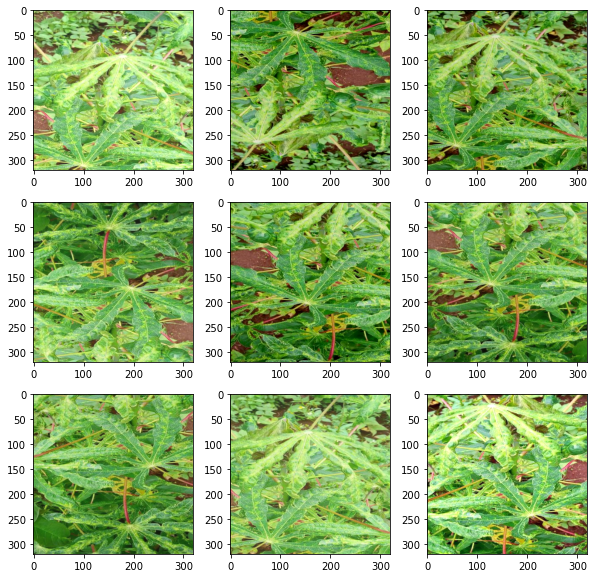

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = image_transform(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image/2+0.5)
#   plt.axis("off")
plt.show()

## CGAN

In [ ]:
import tensorflow as tf
import numpy as np
import sys
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, LeakyReLU, Flatten, Dropout, Conv2D, Conv2DTranspose
    
# train the generator and discriminator
from tqdm import trange, tqdm
class CGAN:
    def __init__(self, input_shape, latent_dim, num_classes):
        self.latent_dim = latent_dim
        self.n_classes = num_classes
        
        # create the discriminator
        self.discriminator = CGAN.define_discriminator(input_shape=input_shape, n_classes=num_classes)
        # create the generator
        self.generator = CGAN.define_generator(latent_dim, n_classes=num_classes)
        # create the gan
        self.gan_model = CGAN.define_gan(self.generator, self.discriminator)

    def save(self, prefix=''):
        prefix = '' if prefix == '' else prefix+'-'
        # save the generator model
        self.generator.save(prefix+'cgan-generator.h5')
        self.discriminator.save(prefix+'cgan-discriminator.h5')
        np.savez_compressed(prefix+'cgan-info.npz', history=self.history, num_classes=self.n_classes, latent_dim=self.latent_dim)
        
    def fit(self, dataset, epochs=1, steps_per_epoch=None, verbose=1, num_iterations_per_batch=1):
#         print('fit')
        history = {key:[] for key in ['d_loss1', 'd_loss2', 'g_loss', 'd_acc1', 'd_acc2']}
        # manually enumerate epochs
        for epoch in range(epochs):
            steps = 0
            iterator = iter(dataset)
            with tqdm(total=steps_per_epoch, ncols=108, leave=True, disable=(verbose==0)) as pbar:
                arr_d_loss1, arr_d_loss2, arr_g_loss = [], [], []
                arr_d_acc1, arr_d_acc2 = [], []
                m_d_loss1, m_d_loss2, m_g_loss = 0, 0, 0
                while True:# i in t:
                    try:
                        image_batch, label_batch = iterator.get_next()
                        it_d_loss1, it_d_loss2, it_g_loss, it_d_acc1, it_d_acc2 = [], [], [], [], []
                        for it in range(num_iterations_per_batch):
                            [d_loss1, d_loss2, g_loss, d_acc1, d_acc2] = self.train_on_step(image_batch, label_batch)
                            it_d_loss1.append(d_loss1); it_d_loss2.append(d_loss2); it_g_loss.append(g_loss)
                            it_d_acc1.append(d_acc1); it_d_acc2.append(d_acc2)
                        d_loss1 = np.mean(it_d_loss1); d_loss2 = np.mean(it_d_loss2); g_loss = np.mean(it_g_loss)
                        d_acc1 = np.mean(it_d_acc1); d_acc2 = np.mean(it_d_acc2)
                        del image_batch, label_batch
                        arr_d_loss1.append(d_loss1); arr_d_loss2.append(d_loss2); arr_g_loss.append(g_loss)
                        arr_d_acc1.append(d_acc1); arr_d_acc2.append(d_acc2)
                        
                        steps += 1
                        update_m = lambda xm, x, Nnew: xm + (x - xm)/Nnew
                        m_d_loss1 = update_m(m_d_loss1, d_loss1, steps)
                        m_d_loss2 = update_m(m_d_loss2, d_loss2, steps)
                        m_g_loss  = update_m(m_g_loss, g_loss, steps)
                        # summarize loss on this batch
                        log_text = f'[epoch:{epoch+1:2.0f}/{epochs}] d_loss1:{m_d_loss1: 2.3f}, d_loss2:{m_d_loss2: 2.3f}, g_loss:{m_g_loss: 2.3f}'
                        pbar.set_description(log_text)
                        pbar.update(1) # to show immediately the update
                    except StopIteration:
                        steps_per_epoch = steps
                        break
                    if steps_per_epoch is not None and steps >= steps_per_epoch: break
            del iterator
#             history['d_loss1'].append(arr_d_loss1); history['d_loss2'].append(arr_d_loss2); history['g_loss'].append(arr_g_loss)
            history['d_loss1'].append(arr_d_loss1); history['d_loss2'].append(arr_d_loss2); history['g_loss'].append(arr_g_loss)
            history['d_acc1'].append(arr_d_acc1); history['d_acc2'].append(arr_d_acc2);
        history['d_loss1']=np.array(history['d_loss1']); history['d_loss2']=np.array(history['d_loss2']); history['g_loss']=np.array(history['g_loss'])
        history['d_acc1']=np.array(history['d_acc1']); history['d_acc2']=np.array(history['d_acc2']); 
        self.history = history
        return history 
    
    def train_on_step(self, image_batch, label_batch):# g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, batch_size=128):
        half_batch = image_batch.shape[0]
        batch_size = half_batch * 2
        latent_dim = self.latent_dim

        # get randomly selected 'real' samples
        X_real, labels_real, y_real = image_batch, label_batch, tf.ones((half_batch, 1))
        # update discriminator model weights
        d_loss1, d_acc1 = self.discriminator.train_on_batch([X_real, labels_real], y_real)
        del X_real, labels_real, y_real

        # generate 'fake' examples
        z_images, z_labels = tf.random.normal((half_batch, latent_dim)), tf.experimental.numpy.random.randint(0, self.n_classes, size=half_batch)
        X_fake, y_fake = self.generator.predict([z_images, z_labels]), tf.zeros((half_batch,1))   
        #         X_fake, labels, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        d_loss2, d_acc2 = self.discriminator.train_on_batch([X_fake, z_labels], y_fake)
        del z_images, z_labels, X_fake, y_fake
        # prepare points in latent space as input for the generator
        z_images, z_labels = tf.random.normal((batch_size, latent_dim)), tf.experimental.numpy.random.randint(0, self.n_classes, size=batch_size)
        # create inverted labels for the fake samples
        y_gan = tf.ones((batch_size, 1))
        # update the generator via the discriminator's error
        g_loss = self.gan_model.train_on_batch([z_images, z_labels], y_gan)
        del z_images, z_labels, y_gan
        return d_loss1, d_loss2, g_loss, d_acc1, d_acc2
        
    ####################################################################################################
    # define the standalone generator model
    def define_generator(latent_dim, n_classes=5):
        # image_size : 320 x 320
        # label input
        in_label = Input(shape=(1,))
        # embedding for categorical input
        li = Embedding(n_classes, 512)(in_label)
        # linear multiplication
        n_nodes = 40 * 40
        li = Dense(n_nodes)(li)
        # reshape to additional channel
        li = Reshape((40, 40, 1))(li)
        # image generator input
        in_lat = Input(shape=(latent_dim,))
        # foundation for 40x40 image
        n_nodes = 128 * 40 * 40
        gen = Dense(n_nodes)(in_lat)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = Reshape((40, 40, 128))(gen)
        # merge image gen and label input
        merge = Concatenate()([gen, li])
        # upsample to 80x80
        gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
        gen = LeakyReLU(alpha=0.2)(gen)
        # upsample to 160x160
        gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
        gen = LeakyReLU(alpha=0.2)(gen)
        # upsample to 320x328
        gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
        gen = LeakyReLU(alpha=0.2)(gen)
        # output
        out_layer = Conv2D(3, (7,7), activation='tanh', padding='same')(gen)
#         out_layer = Concatenate()([])
        # define model
        model = tf.keras.models.Model([in_lat, in_label], out_layer)
        return model

    # define the standalone discriminator model
    def define_discriminator(input_shape=(320,320,3), n_classes=5):
        # label input
        in_label = Input(shape=(1,))
        # embedding for categorical input
        li = Embedding(n_classes, 512)(in_label)
        # scale up to image dimensions with linear activation
#         li = Lambda(debug)(li)
        n_nodes = input_shape[0] * input_shape[1]
        li = Dense(n_nodes)(li)
#         li = Lambda(debug)(li)
        # reshape to additional channel
        li = Reshape((input_shape[0], input_shape[1], 1))(li)
        # image input
        in_image = Input(shape=input_shape)
        # concat label as a channel
        merge = Concatenate()([in_image, li])
        # downsample
        fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
        fe = LeakyReLU(alpha=0.2)(fe)
        # downsample
        fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        # flatten feature maps
        fe = Flatten()(fe)
        # dropout
        fe = Dropout(0.4)(fe)
        # output
        out_layer = Dense(1, activation='sigmoid')(fe)
        # define model
        model = tf.keras.models.Model([in_image, in_label], out_layer)
        # compile model
        opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model
    
    # define the combined generator and discriminator model, for updating the generator
    def define_gan(g_model, d_model):
        # make weights in the discriminator not trainable
        d_model.trainable = False
        # get noise and label inputs from generator model
        gen_noise, gen_label = g_model.input
        # get image output from the generator model
        gen_output = g_model.output
        # connect image output and label input from generator as inputs to discriminator
        gan_output = d_model([gen_output, gen_label])
        # define gan model as taking noise and label and outputting a classification
        model = tf.keras.models.Model([gen_noise, gen_label], gan_output)
        # compile model
        opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt)
        return model


In [ ]:
image_size = [320,320]
with strategy.scope():
    model = CGAN(input_shape=[*image_size, 3], latent_dim=100, num_classes=5)

# train model
history = model.fit(solid_dataset, epochs=8, steps_per_epoch=128, num_iterations_per_batch=4, verbose=1)
model.save()

[epoch: 1/8] d_loss1: 0.328, d_loss2: 0.327, g_loss: 5.712: 100%|█████████| 128/128 [08:40<00:00,  4.07s/it]
[epoch: 2/8] d_loss1: 0.364, d_loss2: 0.292, g_loss: 4.058: 100%|█████████| 128/128 [08:33<00:00,  4.01s/it]
[epoch: 3/8] d_loss1: 0.413, d_loss2: 0.334, g_loss: 3.438: 100%|█████████| 128/128 [08:37<00:00,  4.05s/it]
[epoch: 4/8] d_loss1: 0.430, d_loss2: 0.343, g_loss: 3.212:  77%|███████▋  | 99/128 [06:50<03:12,  6.65s/it]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(18,5))

plt.subplot(121)
plt.plot(np.concatenate(history['d_loss1']), label='d_loss1')
plt.plot(np.concatenate(history['d_loss2']), label='d_loss2')
plt.plot(np.concatenate(history['g_loss']), label='g_loss')
plt.legend(); plt.ylim([0,30])
plt.xlabel('batchs')

plt.subplot(122)
plt.plot(np.mean(history['d_loss1'], axis=1), label='d_loss1')
plt.plot(np.mean(history['d_loss2'], axis=1), label='d_loss2')
plt.plot(np.mean(history['g_loss'], axis=1), label='g_loss')
plt.legend(); plt.ylim([0,30])
plt.xlabel('epochs')

# plt.plot(history['d_loss1'], label='d_loss1')
# plt.plot(history['d_loss2'], label='d_loss2')
# plt.plot(history['g_loss'], label='g_loss')
# plt.legend(); plt.ylim([0,30])
# plt.xlabel('epochs')
plt.savefig('history-loss')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(18,5))

plt.subplot(121)
plt.plot(np.concatenate(history['d_acc1']), label='d_acc1')
plt.plot(np.concatenate(history['d_acc2']), label='d_acc2')
plt.legend(); plt.ylim([0,30])
plt.xlabel('batch')

plt.subplot(122)
plt.plot(np.mean(history['d_acc1'], axis=1), label='d_acc1')
plt.plot(np.mean(history['d_acc2'], axis=1), label='d_acc2')
plt.legend(); plt.ylim([0,30])
plt.xlabel('epochs')

# plt.plot(history['d_loss1'], label='d_loss1')
# plt.plot(history['d_loss2'], label='d_loss1')
# plt.plot(history['g_loss'], label='g_loss')
# plt.legend(); plt.ylim([0,30])
# plt.xlabel('epochs')

plt.show()

In [ ]:
def create_fake_images(labels, latent_points= None, model_generator=None, filename='cgan-generator.h5'):
    if model_generator is None:
        model_generator = tf.keras.models.load_model('cgan-generator.h5')
    latent_dim = model_generator.input[0].shape[1]
    if latent_points is None:
        latent_points= tf.random.normal((labels.shape[0], latent_dim)) 
    fake_images = model_generator.predict([latent_points, labels])/2+0.5
    return fake_images


In [ ]:
labels = np.arange(5)
fake_images = create_fake_images(labels)
plt.figure(figsize=(5,20))
for i in range(5):
    plt.subplot(5,1,1+i)
    plt.imshow(fake_images[i], label=str(i))
plt.legend()
plt.show()
